# 1. Introduction
Quick exploratory data analysis of [Competitions Ranking Top 100](https://www.nba.com/stats/players/) dataset.<br>
The aim of this notebook to visualize the Kaggle habits that top 100 (grand)masters have in common.<br>
**If you're reading this, please upvote.**

In [1]:
# libraries
import random
import pandas as pd
import numpy as np
import seaborn as sns
import networkx as nx
import datetime
import fuzzywuzzy
from fuzzywuzzy import process
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.gridspec as gridspec
import warnings; warnings.filterwarnings("ignore")

# unhide all rows and columns
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 1000)

# for character encoding
import chardet

# for box-cox transformation
from scipy import stats

# for min_max scaling
from mlxtend.preprocessing import minmax_scaling

# 2. Data Loading
The following lines prevent some errors while loading data, delete them from the code and check for yourselves:
* encoding="latin-1"
* delimiter=";"

Dataset is ranked according to "Points" column.

In [2]:
# load data
dataset = "../input/kaggle-competitions-top-100/Kaggle Competitions Top 100 - Jan 2022.csv"
df = pd.read_csv(dataset, delimiter=";", encoding="latin-1")
df.head(10)

,User,Tier,Company/School,Country,Competitions_Num,Competitions_Gold,Competitions_Silver,Competitions_Bronze,Datasets_Num,Notebooks_Num,Discussions_Num,Points,Profile
0,Dieter,grandmaster,Nvidia,Germany,55,26,10,3,21,38,1043,278218,https://www.kaggle.com/christofhenkel
1,bestfitting,grandmaster,unknown,unknown,47,35,10,1,0,2,250,219575,https://www.kaggle.com/bestfitting
2,Psi,grandmaster,H2O,Austria,47,23,7,0,4,16,2010,190065,https://www.kaggle.com/philippsinger
3,Guanshuo Xu,grandmaster,H2O,United States,60,22,19,2,0,4,258,170062,https://www.kaggle.com/wowfattie
4,Giba,grandmaster,Nvidia,Brazil,223,59,47,31,18,104,947,166401,https://www.kaggle.com/titericz
5,Ilu,grandmaster,Aachen,Germany,45,12,6,3,23,19,848,125822,https://www.kaggle.com/ilu000
6,Ahmet Erdem,grandmaster,Nvidia,Turkey,82,19,24,4,39,48,784,117945,https://www.kaggle.com/aerdem4
7,CPMP,grandmaster,Nvidia,France,66,22,23,4,4,49,9270,115929,https://www.kaggle.com/cpmpml
8,Qishen Ha,grandmaster,LINE,Japan,41,15,8,2,36,18,458,115507,https://www.kaggle.com/haqishen
9,?????? ?????????? KazAnova,grandmaster,H2O,Greece,224,41,58,42,9,17,863,113347,https://www.kaggle.com/kazanova


# 3. Data Cleaning
Have a look at the column names. They usually become useful later on.

In [3]:
df.columns

Index(['User', 'Tier', 'Company/School', 'Country', 'Competitions_Num', 'Competitions_Gold', 'Competitions_Silver', 'Competitions_Bronze', 'Datasets_Num', 'Notebooks_Num', 'Discussions_Num', 'Points', 'Profile'], dtype='object')

In [4]:
# get the number of missing data points per column
missing_values_count = df.isnull().sum()

# look at the number of missing points in the columns
missing_values_count[:]

User                   0
Tier                   0
Company/School         0
Country                0
Competitions_Num       0
Competitions_Gold      0
Competitions_Silver    0
Competitions_Bronze    0
Datasets_Num           0
Notebooks_Num          0
Discussions_Num        0
Points                 0
Profile                0
dtype: int64

# 4. Exploratory Data Analysis
Visualize the data to get a better understanding.<br>
First, quick colum correlation check with network diagram.

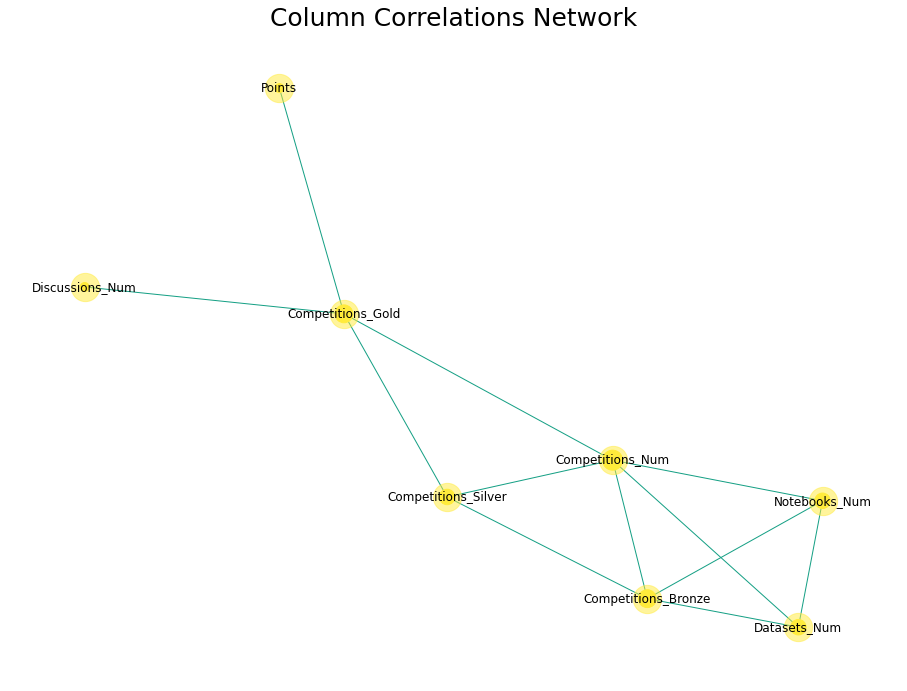

In [5]:
# Column Correlations Network
main_color = "#16a085"
strong_main_color = "#ffeb3b"
custom_colors = [strong_main_color, main_color]

thresh = 0.3
def correlation_network(data, corr_interval=[-0.9, 0.9], data_type="Train", node_color=custom_colors[1]):
    data = data
    corr = data.corr()
    corr = pd.melt(corr.reset_index(), id_vars="index")
    corr.columns = ["x", "y", "value"]
    high_corr = corr[((corr["value"] <= corr_interval[0]) | (corr["value"] >= corr_interval[1]))]
    high_corr = high_corr[(high_corr["value"] != 1)].reset_index(drop=True)
    sources = list(high_corr.x.unique())
    targets = list(high_corr.y.unique())
    plt.figure(figsize=(16, 12))
    g = nx.from_pandas_edgelist(high_corr, source="x", target="y") 
    layout = nx.spring_layout(g, iterations=50, k=0.6, seed=1337)
    target_size = [g.degree(t) * 80 for t in targets]
    nx.draw_networkx_nodes(g, layout, nodelist=targets, node_size=target_size, node_color=node_color)
    nx.draw_networkx_nodes(g, layout, nodelist=sources, node_color=node_color, node_size=800, alpha=0.5)
    nx.draw_networkx_edges(g, layout, width=1, edge_color=custom_colors[1])
    target_dict = dict(zip(targets, targets))
    nx.draw_networkx_labels(g, layout, labels=target_dict)
    plt.axis("off")
    plt.title(f"Column Correlations Network", fontsize=25)
    plt.show()
correlation_network(data=df, corr_interval=[-thresh, thresh], data_type="Train", node_color=custom_colors[0])

In [6]:
# Correlation Matrix
df.corr().style.background_gradient()

,Competitions_Num,Competitions_Gold,Competitions_Silver,Competitions_Bronze,Datasets_Num,Notebooks_Num,Discussions_Num,Points
Competitions_Num,1.000000,0.306443,0.704755,0.920109,0.446285,0.501500,0.082813,0.102994
Competitions_Gold,0.306443,1.000000,0.534129,0.217119,-0.032214,0.151034,0.300766,0.710699
Competitions_Silver,0.704755,0.534129,1.000000,0.697204,0.265664,0.245893,0.187182,0.199847
Competitions_Bronze,0.920109,0.217119,0.697204,1.000000,0.444623,0.412603,0.044890,-0.003474
Datasets_Num,0.446285,-0.032214,0.265664,0.444623,1.000000,0.308192,0.005775,0.011350
Notebooks_Num,0.501500,0.151034,0.245893,0.412603,0.308192,1.000000,0.214921,0.087512
Discussions_Num,0.082813,0.300766,0.187182,0.044890,0.005775,0.214921,1.000000,0.279761
Points,0.102994,0.710699,0.199847,-0.003474,0.011350,0.087512,0.279761,1.000000


Points and number of competitions gold medals are strongly positively correlated.<br>
Also, number of notebooks and number of competitions bronze medals are positively correlated.<br>
Note that, in order to win a bronze medal in a competition, one need to finish at top 100.

## 4.1. Tier 🏆
Majority of the list is grandmaster but 5 experts found themselves a spot at the Top 100.

In [7]:
tier = df.groupby("Tier").User.count().reset_index()
tier

,Tier,User
0,expert,5
1,grandmaster,57
2,master,38


## 4.2. Company/School 🎓
There are only 6 companies with 2 or more employees at Competitions Ranking Top 100.<br>
Nvidia and H2O takes the lead.

In [8]:
company = df.groupby("Company/School").User.count().reset_index()
company[(company.User >= 2)]

,Company/School,User
17,H2O,7
32,Nodalpoint Systems,2
33,Nvidia,8
37,Quant,2
38,Rist,2
54,unknown,30


## 4.3. Country 🌎
Top 100 is from 28 different countries.<br>
Japan and United States holds the majority.<br>
[Ahmet Erdem](https://www.kaggle.com/aerdem4) is the only Turkish Kaggler at Competitions Top 100. Congrats to him!

In [9]:
country = df.groupby("Country").User.count().reset_index()
len(country)

28

In [10]:
df[(df.Country=="Turkey")]

,User,Tier,Company/School,Country,Competitions_Num,Competitions_Gold,Competitions_Silver,Competitions_Bronze,Datasets_Num,Notebooks_Num,Discussions_Num,Points,Profile
6,Ahmet Erdem,grandmaster,Nvidia,Turkey,82,19,24,4,39,48,784,117945,https://www.kaggle.com/aerdem4


In [11]:
country[(country.User >= 5)]

,Country,User
6,China,8
7,France,6
11,India,6
12,Japan,19
25,United States,15
26,Vietnam,5


## 4.4. Content
Mean Competitions: 56<br>
Mean Datasets: 32<br>
Mean Notebooks: 24<br>
Mean Discussions: 432<br>
<br>
Max Competitions: 305 - [Mathurin Aché](https://www.kaggle.com/mathurinache)<br>
Max Datasets: 1197 - [Mathurin Aché](https://www.kaggle.com/mathurinache)<br>
Max Notebooks: 594 - [Bojan Tunguz](https://www.kaggle.com/tunguz)<br>
Max Discussions: 9270 - [CPMP](https://www.kaggle.com/cpmpml)<br>
<br>
It is obvious that masters love to discuss. 😅<br>
And [Giba](https://www.kaggle.com/titericz) loves the gold 🥇 most.

In [12]:
df.describe().round(decimals=0)

,Competitions_Num,Competitions_Gold,Competitions_Silver,Competitions_Bronze,Datasets_Num,Notebooks_Num,Discussions_Num,Points
count,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
mean,56.0,8.0,11.0,6.0,32.0,24.0,432.0,69348.0
std,56.0,9.0,10.0,9.0,124.0,63.0,1172.0,39085.0
min,3.0,0.0,0.0,0.0,0.0,0.0,0.0,40453.0
25%,24.0,3.0,5.0,1.0,1.0,2.0,54.0,44991.0
50%,39.0,5.0,8.0,3.0,6.0,10.0,134.0,53862.0
75%,65.0,9.0,14.0,9.0,21.0,26.0,360.0,77452.0
max,305.0,59.0,58.0,47.0,1197.0,594.0,9270.0,278218.0


In [13]:
df[(df["Competitions_Num"]==305)|(df["Datasets_Num"]==1197)|(df["Notebooks_Num"]==594)|(df["Discussions_Num"]==9270)|(df["Competitions_Gold"]==59)]

,User,Tier,Company/School,Country,Competitions_Num,Competitions_Gold,Competitions_Silver,Competitions_Bronze,Datasets_Num,Notebooks_Num,Discussions_Num,Points,Profile
4,Giba,grandmaster,Nvidia,Brazil,223,59,47,31,18,104,947,166401,https://www.kaggle.com/titericz
7,CPMP,grandmaster,Nvidia,France,66,22,23,4,4,49,9270,115929,https://www.kaggle.com/cpmpml
23,Bojan Tunguz,grandmaster,Nvidia,United States,232,9,17,28,133,594,1425,82069,https://www.kaggle.com/tunguz
34,Mathurin Aché,master,Prevision,France,305,6,35,47,1197,159,99,67748,https://www.kaggle.com/mathurinache


# 5. Conclusion
Competitions and Notebooks relation looks like a cycle of gaining and sharing knowledge.<br>
Top 100 users that have more notebooks than competitions participations are listed below.<br>
Have fun and Kaggle on.

In [14]:
df[((df["Competitions_Num"]<=df["Notebooks_Num"]))]

,User,Tier,Company/School,Country,Competitions_Num,Competitions_Gold,Competitions_Silver,Competitions_Bronze,Datasets_Num,Notebooks_Num,Discussions_Num,Points,Profile
11,Chris Deotte,grandmaster,Nvidia,United States,43,15,13,8,81,79,7019,105518,https://www.kaggle.com/cdeotte
23,Bojan Tunguz,grandmaster,Nvidia,United States,232,9,17,28,133,594,1425,82069,https://www.kaggle.com/tunguz
39,Darek K?eczek,master,P&G,Poland,25,2,2,0,14,59,321,62004,https://www.kaggle.com/thedrcat
48,Takoi,grandmaster,Rist,Japan,36,6,7,2,30,41,113,54726,https://www.kaggle.com/takoihiraokazu
65,Rob Mulla,grandmaster,unknown,United States,84,5,13,10,32,117,1127,49026,https://www.kaggle.com/robikscube
66,beluga,grandmaster,H2O,Hungary,75,14,11,12,14,78,708,48105,https://www.kaggle.com/gaborfodor
74,hirune924,master,NSSOL,Japan,15,4,6,2,58,15,121,45037,https://www.kaggle.com/hirune924
91,Gilles Vandewiele,master,Ghent University,Belgium,22,4,3,2,8,26,702,41796,https://www.kaggle.com/group16
